In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re, string, unicodedata
import nltk
import contractions
import inflect

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import re

from wordcloud import WordCloud, STOPWORDS

import nltk
# import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn import metrics
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

In [2]:
sys_path = "/Users/sigao/Yelp/yelp_dataset/"
## The restaurants in the five candidate cities
busi = pd.read_csv(sys_path+ "business_data_subset.csv", index_col= None)
### reviews in the top 5 candidate cities
rev = pd.read_csv(sys_path + "reviews_data_subset.csv")
### users that are found in the top cities' restaurant reviews
users_ = pd.read_csv(sys_path + "user_data_subset.csv")

In [12]:
users_.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,NaN,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,...,4,5,2,1,33,37,63,63,21,5
2,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",6,...,1,0,0,0,7,14,7,7,2,0
3,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018","3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",78,...,9,2,1,1,22,28,31,31,19,31
4,f4_MRNHvN-yRn7EA8YWRxg,Jennifer,822,2011-01-17 00:18:23,4127,2446,2878,"2011,2012,2013,2014,2015,2016,2017,2018","c-Dja5bexzEWBufNsHfRrQ, 02HJNyOzzYXvEKVApJb8GQ...",137,...,81,62,35,24,193,541,623,623,293,172


### Data Cleaning


In [13]:
## Pick a city
city = "Phoenix"
busi = busi.loc[busi.city == city]
## merge restaurants and ratings to get city info:
rev  = pd.merge(rev, busi[['city',"state",'categories', 'business_id',"review_count"]], how = "inner", on ="business_id")
print(len(rev))
rev.head()

510982


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city_x,state_x,categories_x,review_count_x,city_y,state_y,categories_y,review_count_y
0,UGErdm6bt48SXTVwJIti2Q,QodunSzok4nIYFNrTSGesQ,poSV39UqEg-gpESXafS9-g,3.0,0.0,0.0,0.0,My husband and I go there once a week since la...,2018-03-04 01:03:53,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384
1,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384
2,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384
3,KvJ8yT-dODmCYe21J-Pp_A,gjoN4q-f61kwjmmU4mm1_g,poSV39UqEg-gpESXafS9-g,2.0,0.0,0.0,0.0,"The craft beers are very good, but that's abou...",2016-03-30 22:28:36,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384
4,f88r8XKT_rPrKfyqfwRs3w,zJOGWBbq1mt3RLbKe9XgBg,poSV39UqEg-gpESXafS9-g,4.0,0.0,0.0,0.0,Great HH and awesome catfish dinner for only $...,2017-04-19 11:40:31,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384


In [78]:
rev.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'city_x', 'state_x', 'categories_x',
       'review_count_x', 'city_y', 'state_y', 'categories_y',
       'review_count_y'],
      dtype='object')

In [80]:
x = rev.copy()
x["max_review_date"] = x.groupby(["user_id", "business_id"])["date"].transform(max)
x = x[x["date"] ==  x["max_review_date"]]
x.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city_x,state_x,categories_x,review_count_x,city_y,state_y,categories_y,review_count_y,max_review_date
0,UGErdm6bt48SXTVwJIti2Q,QodunSzok4nIYFNrTSGesQ,poSV39UqEg-gpESXafS9-g,3.0,0.0,0.0,0.0,My husband and I go there once a week since la...,2018-03-04 01:03:53,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,2018-03-04 01:03:53
1,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,2016-01-17 05:33:14
2,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,2016-01-30 01:13:29
4,f88r8XKT_rPrKfyqfwRs3w,zJOGWBbq1mt3RLbKe9XgBg,poSV39UqEg-gpESXafS9-g,4.0,0.0,0.0,0.0,Great HH and awesome catfish dinner for only $...,2017-04-19 11:40:31,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,2017-04-19 11:40:31
5,CfueO6B4_WauGRQ0cq9Whg,fhwZh6_7YxWeVEuskKMTcA,poSV39UqEg-gpESXafS9-g,5.0,2.0,0.0,0.0,Loved this place! \nI came for crab legs and w...,2016-05-07 01:19:53,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,2016-05-07 01:19:53


In [82]:
xx = x.groupby(["user_id", "business_id"]).size()
xx

user_id                 business_id           
---94vtJ_5o_nikEs6hUjg  noCfW7m3z-S1p8KwFIvj2Q    1
---cu1hq55BP9DWVXXKHZg  EGzsR_Tyd0QOaZ6g7wPl-w    1
                        eCJDiRPoSuA0bsb7F1gNUA    1
--1UpCuUDJQbqiuFXkOzaw  kJhQq1BFz7lOYLve7xPaJQ    1
--2HUmLkcNHZp0xw6AMBPg  4j0WfdS_lHG9uSH7cd1PFg    1
                                                 ..
zzpV8L0FOeyejQwomFSDPA  24Td_CQH1bonWKff1rt2vg    1
zzriG-EPaF6yTGbSNC873Q  iXTl2p0w4Fnv8wZNeOEbhw    1
zzsw8F_LGVU-L7hb8357Fw  O2sEX86f6B4GROghjUkr0A    1
zzv3od2Snl1CkHAPVhvVwg  Xdzd_3-eh0sxCZOXGhEWkw    1
zzzAgDDWe4PTnJuwhi3XQQ  PBEUEK39haiJhQzuW4tnYQ    1
Length: 492333, dtype: int64

In [5]:
rating_threshold = 5

def review_filters(data, filtered_var, base_var, threshold):
    '''
    only keep the values of filter_var that meets:
    filter_var[base_var].sum() >= threshold
    '''
    count_df = data[[filtered_var, base_var]].groupby(filtered_var).count()
    valid_id = count_df[count_df[base_var]>=threshold].index.tolist()
    data = data[data[filtered_var].isin(valid_id)]
    return data

In [6]:
# user_id['review_id'].sum() >= 10
reviews_subset = review_filters(rev, 'user_id', 'review_id', rating_threshold)

In [14]:
reviews_subset.describe()

,stars,useful,funny,cool,review_count
count,262292.000000,262292.000000,262292.000000,262292.000000,262292.000000
mean,3.831127,1.575210,0.709004,0.956789,500.972832
std,1.267949,3.683419,2.274797,3.146895,553.023593
min,1.000000,0.000000,0.000000,0.000000,3.000000
25%,3.000000,0.000000,0.000000,0.000000,139.000000
50%,4.000000,1.000000,0.000000,0.000000,317.000000
75%,5.000000,2.000000,1.000000,1.000000,669.000000
max,5.000000,178.000000,169.000000,160.000000,3515.000000


In [17]:
## distribution of reviews per user after trimming
print("unique users:")
reviews_subset.groupby(["user_id"]).size().describe()

unique users:


count    20481.000000
mean        12.806601
std         17.847697
min          5.000000
25%          6.000000
50%          8.000000
75%         13.000000
max        590.000000
dtype: float64

### Content-based Model

#### Collate review documents for each business

In [18]:
reviews_subset.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,state,categories,review_count
1,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384
2,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384
3,KvJ8yT-dODmCYe21J-Pp_A,gjoN4q-f61kwjmmU4mm1_g,poSV39UqEg-gpESXafS9-g,2.0,0.0,0.0,0.0,"The craft beers are very good, but that's abou...",2016-03-30 22:28:36,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384
5,CfueO6B4_WauGRQ0cq9Whg,fhwZh6_7YxWeVEuskKMTcA,poSV39UqEg-gpESXafS9-g,5.0,2.0,0.0,0.0,Loved this place! \nI came for crab legs and w...,2016-05-07 01:19:53,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384
7,S8YMS-nYudRr-_NIT0CZqg,CyL4Nh9VHti5oIfcWevRIg,poSV39UqEg-gpESXafS9-g,5.0,0.0,1.0,2.0,I love sea food and I loved the Angry Crab Sha...,2016-02-11 23:00:41,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384


In [19]:
reviews_subset["review_count2"] = reviews_subset.groupby("business_id")["review_id"].transform(len)
df_revtexts = reviews_subset.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()
print(len(df_revtexts))
df_revtexts

4164


,business_id,text
0,--g-a85VwrdZJNf0R95GcQ,"Love this place! Great tabouleh, falafel and k..."
1,-050d_XIor1NpCuWkbIVaQ,Believe the hype. That's all I can say. \n\nTh...
2,-0WegMt6Cy966qlDKhu6jA,"Great location right outside of the stadium, b..."
3,-0aIra_B6iALlfqAriBSYA,Clean and fresh look/atmosphere. Don't love t...
4,-0tgMGl7D9B10YjSN2ujLA,Great live music! I used to go here a lot more...
...,...,...
4159,zwSqNnr279dQWgNsggOV3w,Grabbed a tea early morning from this new Pane...
4160,zwmps5SXn30g-f5wqg_r9A,The food here is very good and the menu is pre...
4161,zxVw9U56heInhfyprhkxIg,Food is reallyyy good - I always get the chees...
4162,zyAwesOPcP9I-I5Arw8_QA,RUDEST PEOPLE ON THE PLANET. I had a gift car...


In [20]:
df_revtexts["text"][0]

"Love this place! Great tabouleh, falafel and kibbeh. Decor is a little antiseptic so best bet is takeout. Family run business which is great. We have generally went to Sabas but after trying Kabob house we haven't been back to Sabas once.I am always SUPER excited when an authentic ethnic eatery pops up in my hood. And Kabab House definitely did not disappoint!\n\nIt is right by our house and after passing it countless times we finally decided to pick up some takeout for a late lunch.\n\nI ordered the falafel pita and my husband had the chicken schwarma pita. My husband picked it up and said the family that ran the place is so nice. The guy at the counter even gave my husband a free soda because he felt bad about the short wait for food.\n\nHe brought our food home and we were surprised when we opened our food boxes with the enormous serving of french fries that came with the pitas. They were piping hot and sprinkled with a unique seasoning. We were only able to eat about a third of th

In [15]:
all_text = ""
all_snippets = df_revtexts["text"].values
for snippet in all_snippets:
    all_text += snippet

In [16]:
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=6000,height=6000).generate(all_text)

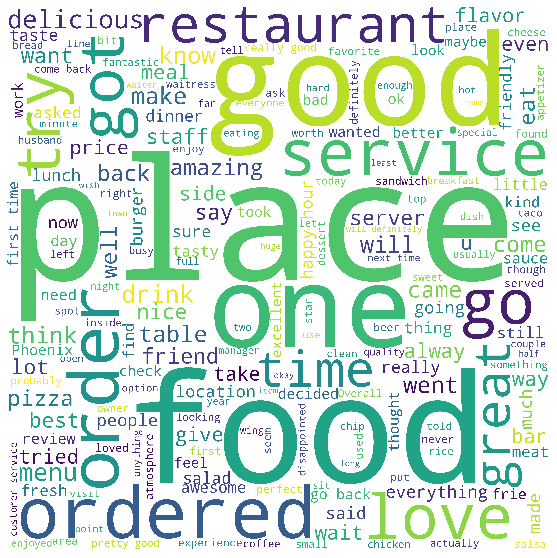

In [17]:
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Text Preprocessing

In [21]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [22]:
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')

def get_processed(sample):
    processed = pd.DataFrame(data=[],columns = ['business_id', 'text'])
    new_texts = []

    for i in range(0, len(sample)):
        business_id = sample['business_id'].iloc[i]
        words = nltk.word_tokenize(sample['text'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[business_id, text]], columns=['business_id', 'text'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)
  
    return processed

In [26]:
processed = get_processed(df_revtexts)
processed.head()

,business_id,text
0,--g-a85VwrdZJNf0R95GcQ,love place great tabouleh falafel kibbeh decor...
1,-050d_XIor1NpCuWkbIVaQ,believ hype say place kama sutra flavor tast b...
2,-0WegMt6Cy966qlDKhu6jA,great locat right outsid stadium smell insid d...
3,-0aIra_B6iALlfqAriBSYA,clean fresh lookatmospher nt love current hour...
4,-0tgMGl7D9B10YjSN2ujLA,great live music use go lot still one favorit ...


### Cosine Similarity

In [30]:
def get_cos_sim_matrix(processed):
    tfidf = TfidfVectorizer(stop_words='english')
    processed['text'] = processed['text'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['text'])
    svd = TruncatedSVD(n_components=10, random_state=42)
    tfidf_truncated = svd.fit_transform(tfidf_matrix) 
    cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
    return cosine_sim

In [50]:
cosine_sim = get_cos_sim_matrix(processed)
cosine_sim.shape

(4164, 4164)

In [44]:
def get_recommendation_cos(processed, reviews, business_id, user_id, cosine_sim, k):
    df_sim = pd.DataFrame(cosine_sim, index=processed['business_id'], columns=processed['business_id'])
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    df_row = df_sim.loc[df_sim.index==business_id]
    df_user = df_row[user_bids]
    results = list(zip(list(df_user.columns), list(df_user.values[0])))
    results_ordered = sorted(results, key=lambda x: x[1], reverse=True)
    results_topk = np.array(results_ordered[1:k+1])
    return results_topk[:,0]

def predict_rating(reviews, user_id, business_ids):
    scores = []
    for bid in business_ids:
        score = reviews.loc[(reviews.user_id==user_id) & (reviews.business_id==bid)]['stars']
        scores.append(score.values[0])
    return np.mean(scores)

def get_results_cos(processed,reviews,business_id,user_id,cosine_sim,k):
    actual = reviews.loc[(reviews.user_id==user_id) & (reviews.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_cos(processed,reviews,business_id,user_id,cosine_sim,k)
    prediction = predict_rating(reviews, user_id, business_ids)
    return actual, prediction

In [27]:
def get_review_processed(processed, reviews):
    reviews_processed = reviews.loc[reviews.business_id.isin(processed.business_id)]\
                           .reset_index()\
                           .drop(columns=['index'])
    return reviews_processed
reviews_processed = get_review_processed(processed, reviews_subset)
print(reviews_processed.shape)
reviews_processed.head()

(262292, 14)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,state,categories,review_count,review_count2
0,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,174
1,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,174
2,KvJ8yT-dODmCYe21J-Pp_A,gjoN4q-f61kwjmmU4mm1_g,poSV39UqEg-gpESXafS9-g,2.0,0.0,0.0,0.0,"The craft beers are very good, but that's abou...",2016-03-30 22:28:36,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,174
3,CfueO6B4_WauGRQ0cq9Whg,fhwZh6_7YxWeVEuskKMTcA,poSV39UqEg-gpESXafS9-g,5.0,2.0,0.0,0.0,Loved this place! \nI came for crab legs and w...,2016-05-07 01:19:53,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,174
4,S8YMS-nYudRr-_NIT0CZqg,CyL4Nh9VHti5oIfcWevRIg,poSV39UqEg-gpESXafS9-g,5.0,0.0,1.0,2.0,I love sea food and I loved the Angry Crab Sha...,2016-02-11 23:00:41,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,174


In [28]:
reviews_processed.shape

(262292, 14)

In [45]:
def get_coverage(processed,reviews,cosine_sim,k):
    reviews_processed = get_review_processed(processed, reviews)
    uid_sample = reviews_processed['user_id'].values
    bid_sample = reviews_processed['business_id'].values

    all_bids = reviews_processed['business_id'].unique()
    pred_bids = []

    for i in range(len(reviews_processed)):
        try:
            business_ids = get_recommendation_cos(processed,
                                            reviews_processed,
                                            bid_sample[i],
                                            uid_sample[i],
                                            cosine_sim,
                                            k)
            pred_bids += list(business_ids)
        except:
            next
    pred_bids = np.array(list(set(pred_bids)))
    return len(pred_bids)/len(all_bids)

In [47]:
uid_sample = reviews_processed['user_id'].values
bid_sample = reviews_processed['business_id'].values
predictions_cos = []
actual_cos = []

In [52]:

count = 0
for i in range(len(reviews_processed)):
    print(i)
    try:
        act, pred = get_results_cos(processed, 
                                reviews_processed, 
                                bid_sample[i], 
                                uid_sample[i], 
                                cosine_sim, 
                                5)
        predictions_cos.append(pred)
        actual_cos.append(act)
    except:
        next
    count+=1
    if count >= 50:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [51]:
get_results_cos(processed,reviews_processed, 
                                bid_sample[0], 
                                uid_sample[0], 
                                cosine_sim, 
                                5)

(5.0, 3.4)

In [53]:
mean_squared_error(predictions_cos, actual_cos)**0.5

1.1214499543002354

In [54]:
display(2,3,12-1)

2

3

11

## LSI Model

In [62]:
reviews_processed.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,state,categories,review_count,review_count2
0,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,174
1,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,AZ,"Restaurants, American (New), Seafood, Cajun/Cr...",384,174


In [74]:
def get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics):
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts] 

    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
    doc = processed['text'].loc[processed.business_id==business_id].values[0]
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = list(index[vec_lsi])
    results = list(zip(user_bids, sims))
    results_ordered = np.array(sorted(results, key=lambda x: x[1], reverse=True))
    results_topk = results_ordered[:5]

    return results_topk[:,0]

def get_results_lsi(processed,reviews,business_id,user_id,k,n_topics):
    actual = reviews.loc[(reviews.user_id==user_id) & (reviews.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics)
    prediction = predict_rating(reviews, user_id, business_ids)
    return actual, prediction

def get_coverage_lsi(processed,reviews,n_topics):
    reviews_processed = get_review_processed(processed, reviews)
    uid_sample = reviews_processed['user_id'].values
    bid_sample = reviews_processed['business_id'].values
    all_bids = reviews_processed['business_id'].unique()
    pred_bids = []

    for i in range(len(reviews_processed)):
        try:
            business_ids = get_recommendation_lsi(processed,
                                            reviews_processed,
                                            bid_sample[i],
                                            uid_sample[i],
                                            5,
                                            n_topics)
            pred_bids += list(business_ids)
        except:
            next
    pred_bids = np.array(list(set(pred_bids)))
    return len(pred_bids)/len(all_bids)

In [75]:

predictions_lsi = []
actual_lsi = []
count = 0
for i in range(len(reviews_processed)):
    print(count)
    try:
        act, pred = get_results_lsi(processed, 
                                reviews_processed, 
                                bid_sample[i], 
                                uid_sample[i], 
                                5,
                                100)
        predictions_lsi.append(pred)
        actual_lsi.append(act)
        count+=1
        if count >= 10:
            break
    except:
        next

0
1
2
3
4
5
6
7
8
9


In [66]:
act, pred = get_results_lsi(processed, 
                                reviews_processed, 
                                bid_sample[0], 
                                uid_sample[0], 
                                5,
                                100)

In [76]:
actual_lsi

[5.0, 5.0, 2.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0]

In [77]:
rmse_lsi = mean_squared_error(predictions_lsi, actual_lsi)**0.5
mae_lsi = mean_absolute_error(predictions_lsi, actual_lsi)
print(f'RMSE: {rmse_lsi}, MAE: {mae_lsi}')

RMSE: 0.8786353054595518, MAE: 0.74


In [ ]:
cov_lsi = get_coverage_lsi(processed,reviews,business,100)
print(f'coverage: {cov_lsi}')